# ▷ 바로가기 이동

### 1. [LMS Node Review](#12-4.-데이터-준비하기)

### 2. [Exploration Project 12. 뉴스 요약봇 만들기](#exploration-project-12)

바로가기 기능은 local에서 동작

<hr>

### 12-4. 데이터 준비하기

오늘 우리가 텍스트 요약 모델 학습에 사용할 데이터셋은 Kaggle에서 제공된 아마존 리뷰 데이터셋입니다.

[Reviews.csv.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/Reviews.csv.zip)

이번 실습에서는 NLTK의 불용어(stopwords)를 사용할 거에요. NTLK와 NLTK 데이터셋이 설치되어 있지 않은 환경이라면 우선 NLTK를 설치하고 NTLK의 데이터셋을 다운로드해 주세요.

NLTK는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리에요. 이 NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있어요. 이를 이용해 다운로드한 리뷰 파일에서 불용어를 제거하는 작업을 진행할 예정이에요.

NLTK 패키지에서 불용어 사전을 다운로드하고, 데이터 전처리를 위한 나머지 패키지도 함께 불러와 볼까요.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


링크에서 다운로드 받은 데이터(Reviews.csv)는 총 568,454개의 샘플을 갖고 있어요. 시간상 여기서는 모든 샘플을 사용하지는 않고, 간단히 10만 개의 샘플만 사용해볼게요.



In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


출력된 샘플 수를 보면 총 10만 개의 샘플이 잘 불러와진 것을 확인할 수 있습니다. 이 중에 5개만 출력해볼까요?

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


열이 너무 많아서 보기에 조금 까다롭죠. 사실 전체 데이터 중 Summary 열과 Text 열만 훈련에 사용할 거라, 이 두 개의 열만 별도로 저장하고, 다시 출력해볼게요.



In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
47420,I just started feeding my cats this brand of f...,Exceptional dog food!
8479,"Delicious coffee, good medium blend. Its hard...",Delicious
29811,"As in the words of Charles Dickens...""My dear,...",It's always tea time!
37298,Very pleased with the product and the lightnin...,Very Pleased
98537,"I am a fan of Larabars in general, and this is...",yummy!
44705,Great concept and they are pretty tasty -- ver...,Good despite faint terrible fake sugar taste
99415,"Need more flavors in the small mints, Spearmin...",Need more small mints
43384,"I got this for a gift, and I got great complim...",fantastico
57113,When my local supermarket stopped carrying Bra...,Best bran cereal on the market
64527,"I used to drink rich, strong coffee, but the c...","strong, dark, flavorful decaf!"


2개의 열이 남았네요. Text 열의 내용을 요약한 것이 Summary 열이에요. 여기서는 인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킬 거예요.




&nbsp;

### 12-5. 데이터 전처리하기 (1) 데이터 정리하기


이제 데이터를 불러왔으니 전처리를 진행해 볼게요. 빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 솎아낼 거예요.



__중복 샘플과 NULL 값이 존재하는 샘플 제거__

<hr>

우선 데이터의 중복 샘플 유무를 확인해 볼게요.



In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


중복을 제외한다면 Text에는 88,426개, Summary에는 72,348개의 유니크한 데이터가 존재해요. 사실 이 데이터의 Summary는 'Smelly'나 'Good Product'와 같이 아주 간단한 요약들도 많아서 Text가 달라도 Summary는 동일할 수 있어요. 하지만 Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야겠죠.

데이터프레임의 `drop_duplicates()` 를 사용하면, 손쉽게 중복 샘플을 제거할 수 있어요.

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


중복이 제거되면서 샘플 수가 88,426개로 줄어들었어요. 그런데 만약 데이터 Null 값을 가지는 샘플이 있었다면, `drop_duplicates()` 가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수 있어요. 데이터에 Null 값이 남아있는지 볼게요.

데이터프레임에 Null 값이 있는지 확인하는 방법은 `.isnull().sum()` 을 사용하면 알아볼 수 있어요.

In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


Summary에 1개의 Null 값이 있네요. 데이터프레임에서 Null을 제거할 때는 `dropna()` 함수를 사용하면 돼요.

In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


__텍스트 정규화와 불용어 제거__

<hr>

살아남은 88,425개의 샘플에는 수많은 단어들이 있어요. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있어요.

예를 들어서 `it'll` 은 `it will` 과 같고, `mustn't` 과 `must not` 은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이에요.

이러한 방법론을 텍스트 처리에서는 __텍스트 정규화(text normalization)__ 라고 해요.

여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성할 거예요. 이 사전은 아래의 링크에서 참고하여 만들었어요.

- [정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)



In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


이제 정규화 준비까지 마쳤어요.

하지만 아직 끝난 게 아니에요. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재해요. 이를 불용어(stopwords)라고 불러요. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 거예요.

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있죠. 이를 사용하여 불용어를 제거할 거예요. 이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 거예요.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같습니다. 이 처리를 위해서 함수의 인자로 `remove_stopwords` 를 추가하고, if문을 추가했어요.

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')


=3


전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출해 볼까요.



In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, `<br />` 과 같은 html 태그가 제거되었죠. `(or finish)` 와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요. 또한 특수문자가 제거되면서 영어만 남았어요.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼게요. 이때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해볼게요.

In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


이제 Summary에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어줄게요.

In [14]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋아요. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되면 샘플 자체가 빈 값을 가지게 되겠죠.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장할게요. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체해요.

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


이전과 같이 `.isnull().sum()` 을 사용해서 Null 값이 생겼는지 해볼게요.

In [16]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

Summary 열에서 70개의 Null 값이 생겼네요. 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개나 생겼다는 의미예요. 이 샘플들은 모두 제거해줄게요.

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


&nbsp;

### 12-6. 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 해요.

__샘플의 최대 길이 정하기__

<hr>

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


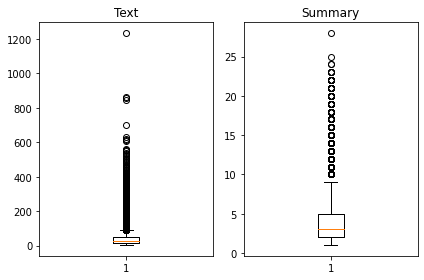

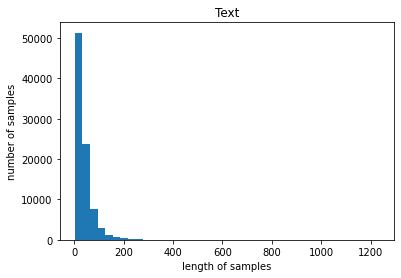

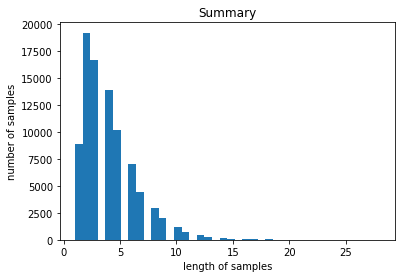

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 돼요. 위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있어요.

Text의 경우 최소 길이가 2, 최대 길이가 1,235로 그 차이가 굉장히 크죠. 하지만 평균 길이는 38로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있어요.

Summary의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧아요. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있네요.

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해볼게요.

In [19]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


각각 50과 8로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠.



In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 하네요.

우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

In [22]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


__시작 토큰과 종료 토큰 추가하기__

<hr>

앞서 시작 토큰과 종료 토큰에 대해서 언급했던 것을 기억하시나요? 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.

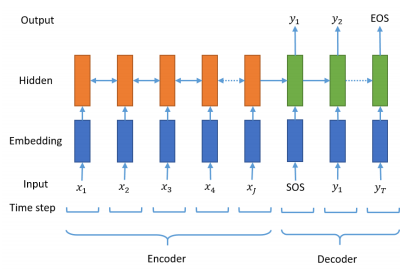 <br>[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다]<br>[https://arxiv.org/pdf/1812.02303.pdf](https://arxiv.org/pdf/1812.02303.pdf)


seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요. 이번 실습에서는 시작 토큰은 `sostoken` , 종료 토큰은 `eostoken` 이라 임의로 명명하고 앞, 뒤로 추가할 거예요. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 `decoder_input` , 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 `decoder_target` 이라고 이름을 정했어요. 두 개의 문장 모두 Summary 열로부터 만들 거예요.

In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


앞뒤로 토큰이 잘 붙었죠? 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.

In [24]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


이제 훈련 데이터와 테스트 데이터를 분리할거에요.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해볼게요. 우선, `encoder_input` 과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[32497 40758 36090 ... 55504 47580 35088]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.

In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요. :표시의 위치에 주의해 주세요.

In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


훈련 데이터와 테스트 데이터가 각각 52,655개와 13,163개로 잘 분리된 것을 볼 수 있어요!




&nbsp;

### 12-7. 데이터 전처리하기 (3) 정수 인코딩

__단어 집합(vocabulary) 만들기 및 정수 인코딩__

<hr>

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요. 훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 `encoder_input_train` 에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.



In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 `src_tokenizer.word_index` 에 저장되어 있어요. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.



`src_tokenizer.word_counts.items()` 에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.



In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31910
등장 빈도가 6번 이하인 희귀 단어의 수: 23656
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8254
단어 집합에서 희귀 단어의 비율: 74.13350047007208
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3755204429764727


`encoder_input_train` 에는 3만여 개의 단어가 있네요. 그 아래의 통계 정보들을 해석해볼까요?



등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지하네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않아요.



그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.



In [31]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


`texts_to_sequences()` 는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.



In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[177, 402, 369, 485, 780, 55, 402, 369, 106, 4], [34, 869, 41, 434, 56, 143, 6146, 1, 1636, 41, 2, 79, 38, 14], [1209, 220, 272, 578, 1335, 220, 45, 272, 1837, 1335, 220]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.



Summary 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 `decoder_input_train` 을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.



In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 `tar_tokenizer.word_index` 에 저장되어 있어요. `tar_tokenizer.word_counts.items()` 에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.



In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10549
등장 빈도가 5번 이하인 희귀 단어의 수: 8144
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2405
단어 집합에서 희귀 단어의 비율: 77.20163048630202
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.864809419552812


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않아요. 아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 2,000을 단어 집합의 크기로 제한할게요.



In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 83, 6, 74], [1, 71], [1, 6, 5, 380], [1, 329, 43, 6, 97, 1010], [1, 12, 10, 171]]
target
decoder  [[83, 6, 74, 2], [71, 2], [6, 5, 380, 2], [329, 43, 6, 97, 1010, 2], [12, 10, 171, 2]]


정상적으로 정수 인코딩 작업이 끝났어요. 현재 `decoder_input_train` 과 `decoder_target_train` 에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 `decoder_input` 에는 `sostoken` 또는 `decoder_target` 에는 `eostoken` 이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0 이 된 `decoder_input` 에는 `sostoken` , `decoder_target` 에는 `eostoken` 만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 `drop_train` 과 `drop_test` 에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.



In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1280
삭제할 테스트 데이터의 개수 : 326
훈련 데이터의 개수 : 51375
훈련 레이블의 개수 : 51375
테스트 데이터의 개수 : 12837
테스트 레이블의 개수 : 12837


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있어요. 이제 거의 다 왔어요.



__패딩하기__


텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


이제 학습에 필요한 데이터 전처리가 모두 끝났어요.




&nbsp;

### 12-8. 모델 설계하기


이제는 모델을 설계할 시간이에요. 우선 함수형 API를 이용해서 인코더를 설계해 볼게요.



In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?



또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있어요. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이에요.



반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이에요. 즉 time step의 입력을 랜덤으로 생략해 주는 거죠. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 해요.



아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것입니다. 색이 있는 화살표는 dropout을 나타낸 것이에요. (색이 다른 것은 다른 dropout mask를 사용했다는 표시인데, 지금은 그냥 넘어가셔도 됩니다.) 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용할 수 있습니다. 그렇게 되면 오른쪽 그림과 같은 형태가 되겠군요. 참고로 dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 해요.



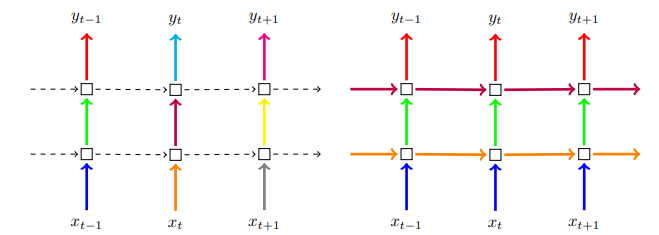 <br>[dropout(왼쪽)과 dropout + recurrent dropout(오른쪽)]<br>[https://arxiv.org/pdf/1512.05287.pdf](https://arxiv.org/pdf/1512.05287.pdf)

> 참고로 recurrent dropout을 사용하면 아래와 같은 경고문이 뜹니다.
>
>~~~
    WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
>~~~
>recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸립니다.


recurrent dropout에 대한 자세한 내용은 아래의 논문을 참고하세요.

 - [Recurrent Dropout without Memory Loss](https://arxiv.org/pdf/1603.05118v2.pdf)
 

이제 디코더를 설계해볼게요!

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, `initial_state` 의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

디코더의 출력층을 설계해볼게요.



In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 `tar_vocab` 의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요. 그렇기 때문에 Dense의 인자로 `tar_vocab` 을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 어텐션 메커니즘이에요.

&nbsp;

__어텐션 메커니즘__


어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다. 이 어텐션에 대한 자세한 설명은 [텐서플로우 홈페이지](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)를 참고하세요.

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.



In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.




&nbsp;

### 12-9. 모델 훈련하기


설계한 모델을 가지고 훈련을 진행해볼게요.


In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 50s 152ms/step - loss: 2.7051 - val_loss: 2.4170
Epoch 2/50
201/201 [==============================] - 30s 149ms/step - loss: 2.3653 - val_loss: 2.2532
Epoch 3/50
201/201 [==============================] - 29s 146ms/step - loss: 2.2096 - val_loss: 2.1358
Epoch 4/50
201/201 [==============================] - 30s 147ms/step - loss: 2.0964 - val_loss: 2.0604
Epoch 5/50
201/201 [==============================] - 30s 147ms/step - loss: 2.0175 - val_loss: 2.0036
Epoch 6/50
201/201 [==============================] - 30s 147ms/step - loss: 1.9550 - val_loss: 1.9677
Epoch 7/50
201/201 [==============================] - 30s 147ms/step - loss: 1.9027 - val_loss: 1.9381
Epoch 8/50
201/201 [==============================] - 29s 147ms/step - loss: 1.8569 - val_loss: 1.9196
Epoch 9/50
201/201 [==============================] - 29s 147ms/step - loss: 1.8156 - val_loss: 1.8908
Epoch 10/50
201/201 [==============================] - 30s 147ms/step - l

'조기 종료'를 뜻하는 `EarlyStopping` 은 특정 조건이 충족되면 훈련을 멈추는 역할을 해요.

~~~python
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
~~~

위 코드에서는 `val_loss`(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있어요. `EarlyStopping` 이 작동한다면 `epochs` 가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.

`EarlyStopping` 에 대한 자세한 내용은 아래 링크를 참고하세요! 자주 쓰이는 도구이니 자세히 알아두면 매우 도움이 될 거예요!!

- [Early Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해봐요.



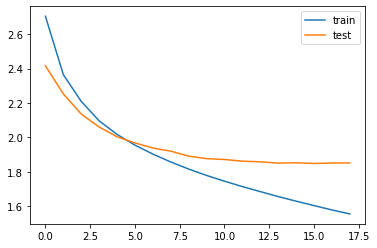

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

&nbsp;

### 12-10. 인퍼런스 모델 구현하기


테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.



In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.



그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.



In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.



In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


&nbsp;

### 12-11. 모델 테스트하기


테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.



In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : love jolly rancher stix break pieces enjoy longer time working simply watching tv came well package solid broken pieces taste always 
실제 요약 : my favorites 
예측 요약 :  not as advertised


원문 : decided go decaf coffee shopping around tried several brands finally came coffee masters brand love love love aroma awesome flavor even better nuff said 
실제 요약 : coffee decaf vanilla nut creme coffee 
예측 요약 :  best decaf coffee


원문 : product tastes better original variety macaroni little bit longer original makes slightly difficult toddler eat cheese takes little stirring melt incorporate however great taste makes little knowing organic makes happy 
실제 요약 : delicious 
예측 요약 :  great for those


원문 : caffeine acidity coffee problem coffee nice medium roast less two products mentioned really tastes good made arabica beans 
실제 요약 : melitta lite coffee 
예측 요약 :  great coffee


원문 : flavor reminded somewhat candy cannot recall one fruity sweet would give kids regular sugar laden soda ingredients in

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보이네요. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 하네요. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다. 이런 방안들에 대해서도 향후 살펴보게 될 것입니다.

&nbsp;

### 12-12. 추출적 요약 해보기


앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.

패키지 `Summa` 에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀볼까요?

__데이터 다운로드하기__

<hr>

매트릭스 시놉시스를 다운로드 해주세요.

In [50]:
import requests
from summa.summarizer import summarize

text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

이제 text에는 매트릭스 시놉시스가 문자열로 저장돼 있어요. 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해볼게요.



In [51]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

__summarize 사용하기__

<hr>

Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.



> text (str) : 요약할 테스트.<br>
>
> ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값<br>
>
> words (int or None, optional) – 출력에 포함할 단어 수.<br>
>
> 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.<br>
>
> split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환<br>

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력하도록 설정했어요.

In [52]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 돼요.



In [53]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


단어의 수로 요약문의 크기를 조절할 수도 있어요. 단어를 50개만 선택하도록 해보세요.



In [54]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


&nbsp;

### 12-13. 프로젝트: 뉴스기사 요약해보기


새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [55]:
from importlib.metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


### Step 1. 데이터 수집하기

<hr>

데이터는 아래 링크에 있는 뉴스 기사 데이터(`news_summary_more.csv`)를 사용하세요.

- [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

아래의 코드로 데이터를 다운로드할 수 있어요.



In [56]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [57]:
data.sample(10)

,headlines,text
60637,Maha govt might make VIPs pay for police prote...,Maharashtra government will come out with a dr...
98058,Arunachal boy invents goggles for blind to loc...,"A Class 11 student from Arunachal Pradesh, Ana..."
30825,Father throws party after son fails class 10 b...,A civil contractor in Madhya Pradesh threw a l...
21826,Ronaldo takes 8 minutes to score 1st goal on J...,Cristiano Ronaldo scored his first goal for Ju...
7200,I feel insulted: Vasundhara on being called 'f...,After Loktantrik Janata Dal leader Sharad Yada...
71457,ID proof to be mandatory for booking domestic ...,Passengers may have to submit the details of t...
71910,Aishwarya features on cover of Grazia's Septem...,Aishwarya Rai Bachchan has featured on the cov...
87736,Father-son duo turn car into a working 'Transf...,A father-son duo in Russia have remade a VAZ-2...
3352,No political motive behind raids on film stars...,Addressing the income tax raids on multiple Ka...
86218,Indian team avoided Vijay Mallya at charity ev...,Members of the Indian cricket team reportedly ...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.



추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

### Step 2. 데이터 전처리하기 (추상적 요약)

<hr>

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

<hr>

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

<hr>

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

### Step 5. Summa을 이용해서 추출적 요약해보기

<hr>

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.



&nbsp;

<hr>

# Exploration Project 12

### Create news summary bot

&nbsp;

### Step 0. 라이브러리 확인
<hr>

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from importlib.metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.2.0


&nbsp;

### Step 1. 데이터 수집하기

<hr>

데이터는 아래 링크에 있는 뉴스 기사 데이터(`news_summary_more.csv`)를 사용한다.

- [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

아래의 코드로 데이터를 다운로드할 수 있다.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
# data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data = pd.read_csv('news_summary_more.csv', encoding='utf8')

In [4]:
## 갯수만큼 랜덤 샘플 출력
data.sample(10)

,headlines,text
68621,Oscar-winner Scorsese to teach filmmaking onli...,Oscar-winning filmmaker Martin Scorsese will b...
57678,PM Modi finally sees Rahul as serious competit...,In its mouthpieces 'Saamana' and 'Dopahar Ka S...
79182,I benefitted a lot from the 'serial kisser' ta...,Actor Emraan Hashmi has said he benefitted a l...
29396,Bengaluru mob attacks 3 women over child-kidna...,A mob in Bengaluru's Whitefield area on Friday...
94475,"Man behind â¹2,000 crore call centre scam arr...",Mumbai police said on Saturday they have arres...
70075,In Pics: Highlights of Cassini's 20-year missi...,"NASA's Cassini spacecraft, on Friday dove into..."
46913,Dalit woman to contest Senate elections in Pak...,Krishna Kumari has become the first Dalit woma...
83520,It's between me and God: Pak man who stole fro...,"A man on Friday stole Pakistani Rs 50,000 from..."
39346,Shah Rukh Khan's cousin to contest Pak general...,Shah Rukh Khan's paternal cousin Noor Jahan ha...
47946,Writer gives Sahitya Akademi money to lynching...,"Malayalam writer KP Ramanunni, who was present..."


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다.


In [5]:
## 전체 데이터 중 훈련에 사용할 열만 다시 정리한다.
## text 는 본문, headlines 는 요약된 데이터이다.

## 노드 실습 부분과의 연계를 고려하여 컬럼 이름을 바꿔서 사용하도록 하겠다.
data1 = data[["text", "headlines"]]
data1.rename(columns={"text":"Content", "headlines":"Headlines"}, inplace=True)
data2 = data[["text", "headlines"]]
data2.rename(columns={"text":"Text", "headlines":"Summary"}, inplace=True)
data = pd.concat([data1, data2],axis=1)

이렇게 원본 텍스트를 보존하도록 하겠다. 추후, 추출적 요약에 사용할 것이다.

In [6]:
data.head()

,Content,Headlines,Text,Summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


In [7]:
data.tail()

,Content,Headlines,Text,Summary
98396,A CRPF jawan was on Tuesday axed to death with...,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...,CRPF jawan axed to death by Maoists in Chhatti...
98397,"'Uff Yeh', the first song from the Sonakshi Si...",First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si...",First song from Sonakshi Sinha's 'Noor' titled...
98398,"According to reports, a new version of the 199...",'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199...",'The Matrix' film to get a reboot: Reports
98399,A new music video shows rapper Snoop Dogg aimi...,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...,Snoop Dogg aims gun at clown dressed as Trump ...
98400,"Madhesi Morcha, an alliance of seven political...",Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political...",Madhesi Morcha withdraws support to Nepalese g...


In [8]:
data.shape

(98401, 4)

총 98401 개의 데이터가 있다.

- Content：text 의 원본


- Headlines：headlines 의 원본


- 추상적 요약을 하는 경우：Text를 본문, Headlines를 이미 요약된 데이터로 삼아서 모델 학습에 활용


- 추출적 요약을 하는 경우：오직 text열(여기서는 Content열)만을 사용

&nbsp;

### Step 2. 데이터 전처리하기 (추상적 요약)

<hr>

노드의 실습부분에서 사용된 전처리를 참고하여 전처리를 진행하도록 하겠다.

__◆ 중복 샘플과 NULL 값이 존재하는 샘플 제거__


In [9]:
## 데이터의 중복 샘플 유무를 확인
print("Text 열에서 중복을 배제한 유일한 샘플의 수 :", data["Text"].nunique())
print("Summary 열에서 중복을 배제한 유일한 샘플의 수 :", data["Summary"].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [10]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset=["Text"], inplace=True)
data.drop_duplicates(subset=["Summary"], inplace=True)
print("전체 샘플수 :", (len(data)))

전체 샘플수 : 98262


중복을 제거하였다.

혹시 Null 값이 남아 있는지 확인해보자.

In [11]:
## Null 값이 남아있는지 확인
print(data.isnull().sum())

Content      0
Headlines    0
Text         0
Summary      0
dtype: int64


In [12]:
## 데이터프레임에서 Null 값을 제거
data.dropna(axis=0, inplace=True)
print("전체 샘플수 :", (len(data)))
## 여기선 사실 이 코드가 작동 할 일은 없지만, 절차적으로 기록하고자 사용했다.

전체 샘플수 : 98262


__◆ 텍스트 정규화와 불용어 제거__

- 텍스트 정규화(text normalization)

  + 같은 의미인데 다른 표현으로 쓰여 마치 다른 단어들 처럼 간주되는 단어를<br>
  기계 학습 전에 미리 같은 표현으로 통일시켜 주는 과정.

  + 기계의 연산량을 줄일 수 있다.
  
  + [정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

정규화 사전을 가져와 사용하도록 하겠다.

In [13]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- 불용어(stopwords)
  + 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어.
  + 불용어를 제거가 자연어 처리의 성능을 높일 수 있다.

NLTK 에서 제공하는 불용어 리스트를 사용하도록 하겠다.

In [14]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

노드 실습 부분에서는 데이터 전처리 함수를 정의 할 때,

NLTK 를 이용해 불용어를 제거하는 부분을 필요에 따라 remove_stopwords 지정을 통해

불용어 제거 여부를 결정 할 수 있게 하도록 하고 있다.

그 외, 모든 영어문자의 소문자 변환 및 섞여 있는 html 태그등을 제거하고,

정규표현식을 사용하여 각종 특수문자를 제거하는 등의 과정을 포함하도록 하여

preprocess_sentence 함수를 정의하겠다.

In [15]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r"\([^)]*\)", "", sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub("\"","", sentence) # 쌍따옴표 " 제거
    sentence = " ".join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[m]{2,}", "mm", sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = " ".join(word for word in sentence.split() if not word in stopwords.words("english") if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = " ".join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 전, 후의 결과를 확인하기 위해 함수를 호출해 보자.

In [16]:
temp_text = "Everything I bought wasn't great, <br>infact I <font>ordered<font/> " + \
"twice and the third ordered was<br/>for my mother and father."
temp_summary = "we don't Great way to start (or finish) the day!!!"

print("Text :", preprocess_sentence(temp_text))
print("Summary :", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

Text : everything bought great infact ordered twice third ordered wasfor mother father
Summary : we do not great way to start the day


이제 훈련 데이터 전체에 대해서 전처리를 적용 하겠다.

우선 Text의 경우에는 불용어 제거, Summary의 경우에는 불용어를 제거하지 않겠다.

그리고 결과를 확인하기 위해서 상위 5개의 줄을 출력해보겠다.

In [17]:
from tqdm import tqdm
clean_text = []
origin_text =[]

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['Text']):
    clean_text.append(preprocess_sentence(s))
    origin_text.append(s)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

100%|██████████| 98262/98262 [07:51<00:00, 208.48it/s]

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

Summary에 대해서 전처리 함수를 호출해 줄 때는,

불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어준다.

In [18]:
clean_summary = []
origin_summary =[]

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['Summary']):
    clean_summary.append(preprocess_sentence(s, False))
    origin_summary.append(s)

print("Summary 전처리 후 결과: ", clean_summary[:5])

100%|██████████| 98262/98262 [00:16<00:00, 6060.92it/s]

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [19]:
print("len(clean_text) :", len(clean_text))
print("len(clean_summary) :", len(clean_summary))
print("len(origin_text) :", len(origin_text))
print("len(origin_summary) :", len(origin_summary))

len(clean_text) : 98262
len(clean_summary) : 98262
len(origin_text) : 98262
len(origin_summary) : 98262


텍스트 정제 과정을 거친 후에는 다시 한번 샘플을 확인해 보는 것이 좋다.

정제 과정에서 문장의 단어가 사라지는 경우가 있을 수 있기 때문이다.

데이터들을 다시 데이터프레임으로 저장하고, 빈 값을 가진 샘플들이 있다면, Null 로 대체하겠다.


우선 데이터프레임을 재조합해서 만들겠다.

In [20]:
data.shape

(98262, 4)

In [21]:
df_news_origin_text = pd.DataFrame(origin_text, columns=["Content"])
print(df_news_origin_text.shape)
print(df_news_origin_text.isnull().sum())
df_news_origin_summary = pd.DataFrame(origin_summary, columns=["Headlines"])
print(df_news_origin_summary.shape)
print(df_news_origin_summary.isnull().sum())
df_news_text = pd.DataFrame(clean_text, columns=["Text"])
print(df_news_text.shape)
print(df_news_text.isnull().sum())
df_news_summary = pd.DataFrame(clean_summary, columns=["Summary"])
print(df_news_summary.shape)
print(df_news_summary.isnull().sum())
df_news = pd.concat([df_news_origin_text, df_news_origin_summary, df_news_text, df_news_summary], axis=1)
print(df_news.shape)
print(df_news.isnull().sum())

(98262, 1)
Content    0
dtype: int64
(98262, 1)
Headlines    0
dtype: int64
(98262, 1)
Text    0
dtype: int64
(98262, 1)
Summary    0
dtype: int64
(98262, 4)
Content      0
Headlines    0
Text         0
Summary      0
dtype: int64


조합을 정상적으로 마친것을 확인하였다. 이제 빈 값들을 Null 로 바꾸도록 하자.

In [22]:
df_news.replace("", np.nan, inplace=True)

이전과 같이 `.isnull().sum()` 을 사용해서 Null 값이 생겼는지 확인해보자.

In [23]:
df_news.isnull().sum()

Content      0
Headlines    0
Text         0
Summary      0
dtype: int64

Null 값을 제거해주는 코드를 사용하자.

In [24]:
df_news.dropna(axis=0, inplace=True)
print("전체 샘플수 :", (len(df_news)))
## 여기선 사실 이 코드가 작동 할 일은 없지만, 절차적으로 기록하고자 사용했다.

전체 샘플수 : 98262


In [25]:
df_news

,Content,Headlines,Text,Summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim...",speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...
...,...,...,...,...
98257,A CRPF jawan was on Tuesday axed to death with...,CRPF jawan axed to death by Maoists in Chhatti...,crpf jawan tuesday axed death sharp edged weap...,crpf jawan axed to death by maoists in chhatti...
98258,"'Uff Yeh', the first song from the Sonakshi Si...",First song from Sonakshi Sinha's 'Noor' titled...,uff yeh first song sonakshi sinha starrer upco...,first song from sonakshi sinha noor titled uff...
98259,"According to reports, a new version of the 199...",'The Matrix' film to get a reboot: Reports,according reports new version science fiction ...,the matrix film to get reboot reports
98260,A new music video shows rapper Snoop Dogg aimi...,Snoop Dogg aims gun at clown dressed as Trump ...,new music video shows rapper snoop dogg aiming...,snoop dogg aims gun at clown dressed as trump ...


전처리에 시간이 제법 걸려서, 다시 실행할 때를 대비하여 백업을 수행하도록 하겠다.

In [26]:
## 백업 수행
path = os.getenv("HOME")+"/aiffel/news_summarization/data/news.csv"
# df_news.to_csv(path, encoding='iso-8859-1')
df_news.to_csv(path, encoding="utf8")

&nbsp;

### Step 3. 데이터셋 분리와 인코딩

<hr>

학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표기해야 한다.

__샘플의 최대 길이 정하기__

훈련에 사용할 샘플의 최대 길이를 정해보자.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 보도록 하자.

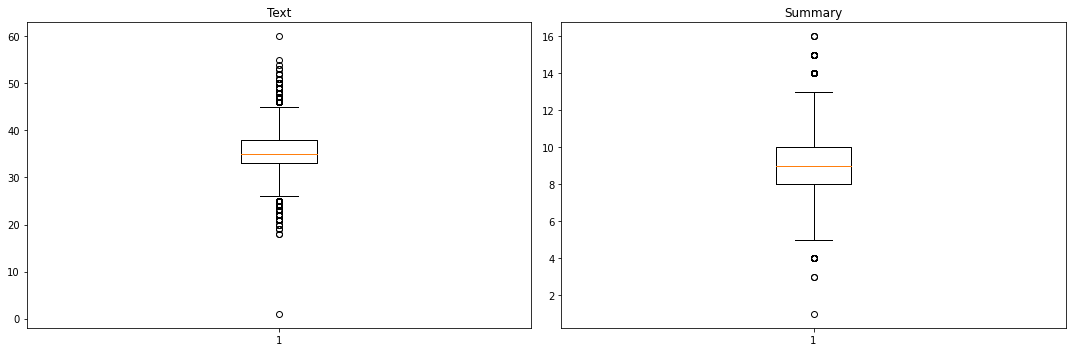

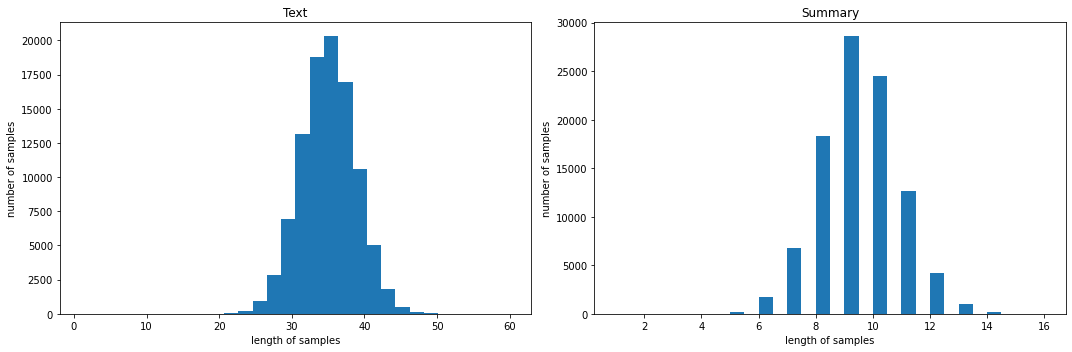

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299444342675704


In [27]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in df_news['Text']]
summary_len = [len(s.split()) for s in df_news['Summary']]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Text')
plt.hist(text_len, bins = 30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(1,2,2)
plt.title('Summary')
plt.hist(summary_len, bins = 30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.tight_layout()
plt.show()

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

최소길이가 1 인 값들이 의심스럽다, 한번 찾아보자.

In [28]:
print(text_len.index(1))
print(summary_len.index(1))

52
52


In [29]:
df_news.loc[52:52]

,Content,Headlines,Text,Summary
52,text,headlines,text,headlines


컬럼명을 text → Text, headlines → Summary 로 바꾸는 부분 테스트 하는 과정에서

괄호 입력 실수로 들어간 데이터로 생각된다. (추후 확인결과, 아니었다, 원래 들어있었다.）삭제 하도록 하겠다.

In [30]:
# index가 52인 행만 삭제
if (df_news.loc[(52), "Text"] == "text"):
    print("삭제")
    df_news = df_news.drop(index=52, axis=0)

삭제


In [31]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98261 entries, 0 to 98261
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Content    98261 non-null  object
 1   Headlines  98261 non-null  object
 2   Text       98261 non-null  object
 3   Summary    98261 non-null  object
dtypes: object(4)
memory usage: 3.7+ MB


다시 값을 확인 해 보면 큰 차이는 없지만 최소 길이가 달라진 것을 확인할 수 있다.

In [32]:
text_len = [len(s.split()) for s in df_news['Text']]
summary_len = [len(s.split()) for s in df_news['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 18
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10064013189363
요약의 최소 길이 : 3
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299528805935214


Text 의 최대 길이와 Summary 의 최대 길이를 일단 정해보도록 하겠다.

In [33]:
text_max_len = 41
summary_max_len = 11
print('=3')

=3


In [34]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [35]:
below_threshold_len(text_max_len, df_news['Text'])
below_threshold_len(summary_max_len,  df_news['Summary'])

전체 샘플 중 길이가 41 이하인 샘플의 비율: 0.9549363430048544
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9450036128270626


Text는 41, Summary는 11 길이보다 길면 제외하는 방법으로 데이터를 다시 정제하도록 하겠다.

In [36]:
df_news = df_news[df_news['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
df_news = df_news[df_news['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(df_news)))

전체 샘플수 : 88659


__시작 토큰과 종료 토큰 추가하기__

 디코더는 시작 토큰을 입력받아 문장을 생성 → 종료 토큰을 예측한 순간 문장 생성을 멈춘다,
 
 seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다.
 
 여기서는 시작 토큰은 `sostoken` , 종료 토큰은 `eostoken` 이라 임의로 명명하고 앞, 뒤에 추가한다.
 
 이하 두 개의 문장 모두 Summary 열로부터 컬럼을 추가하여 생성하겠다.
 
 - `decoder_input`：디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름
 
 - `decoder_target`：디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름 

In [37]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
df_news['decoder_input'] = df_news['Summary'].apply(lambda x : 'sostoken '+ x)
df_news['decoder_target'] = df_news['Summary'].apply(lambda x : x + ' eostoken')
df_news.head()

,Content,Headlines,Text,Summary,decoder_input,decoder_target
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,Pakistani singer Rahat Fateh Ali Khan has deni...,Rahat Fateh Ali Khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,Weeks after ex-CBI Director Alok Verma told th...,Govt directs Alok Verma to join work 1 day bef...,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


토큰이 잘 붙은것을 확인 했다.

이제 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장한다.

In [38]:
encoder_input = np.array(df_news['Text']) # 인코더의 입력
decoder_input = np.array(df_news['decoder_input']) # 디코더의 입력
decoder_target = np.array(df_news['decoder_target']) # 디코더의 레이블

__훈련 데이터와 테스트 데이터 분리__

우선, `encoder_input` 과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만든다.

In [39]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[56824 58349 13704 ... 54750 62583 67008]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의하여 샘플을 섞는다.

In [40]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리한다.
    
전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의하겠다.

In [41]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17731


이 테스트 데이터의 수를 이용해 데이터를 분리한다.

In [42]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 70928
훈련 레이블의 개수 : 70928
테스트 데이터의 개수 : 17731
테스트 레이블의 개수 : 17731


__단어 집합(vocabulary) 만들기 및 정수 인코딩__

- 단어 집합(vocabulary) 만들기

  + 기계가 텍스트를 숫자로 처리할 수 있도록, 단어들을 모두 정수로 바꾸어야 한다.<br>
  이를 위해서 각 단어에 고유한 정수 맵핑이 필요하다.

훈련 데이터에 대해서 단어 집합을 만들겠다.

우선, 원문에 해당되는 `encoder_input_train` 부터 단어 집합을 생성한다.

In [43]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.

현재 생성된 단어 집합은 `src_tokenizer.word_index` 에 저장되어 있다. 

여기서 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행할 것이다.

- `src_tokenizer.word_counts.items()`： 단어와 각 단어의 등장 빈도수 저장, 이를 통해 통계적인 정보를 얻을 수 있다.

등장 빈도수가 12회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [44]:
threshold = 12
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s' %(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", round((rare_cnt / total_cnt)*100 , 3))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", round((rare_freq / total_freq)*100, 3))

단어 집합(vocabulary)의 크기 : 66040
등장 빈도가 11번 이하인 희귀 단어의 수: 50232
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15808
단어 집합에서 희귀 단어의 비율: 76.063
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.534


`encoder_input_train` 에는 6만6천여 개의 단어가 있다.

등장빈도가 threshold 값 미만인 단어들은 단어 집합에서 76％ 가량을 차지하고 있다.

하지만 실제로 훈련 데이터에서 차지하는 비중은 5.55％ 정도이다.

 → threshold 값 미만인 단어들은 정수 인코딩 과정에서 제외하고, 훈련데이터에서 제거할 것이다.

여기서는 단어 집합의 크기를 16,000개 로 제한하도록 하겠다.

토크나이저 정의할 때 num_words 값을 지정하여 단어 집합의 크기를 제한 할 수 있다.

In [45]:
src_vocab = 16000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


- `texts_to_sequences()`
  + 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩 수행



현재 단어 집합의 크기를 16,000 으로 제한했다.

이제 16,000이 넘는 숫자들은 정수 인코딩 후의 데이터에 존재하지 않는다.

In [46]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[206, 1971, 65, 213, 191, 299, 3765, 397, 176, 3, 12154, 1663, 290, 808, 372, 372, 2636, 1733, 2760, 2742, 912, 296, 292, 7852, 6016, 11458], [6221, 79, 379, 487, 2231, 4939, 3639, 15809, 81, 232, 17, 1623, 30, 1878, 15, 3559, 50, 15810, 115, 27, 1644, 232, 153, 30, 15, 4549, 2660, 9618, 3114, 3766, 77, 921, 15810, 567, 58], [11, 1383, 3208, 3115, 3136, 2, 391, 3248, 118, 932, 334, 5882, 391, 883, 963, 216, 59, 3115, 986, 11, 84, 44, 2, 29, 84, 98, 244, 1828, 80, 724, 673, 391, 44]]


이제 Summary 데이터에 대해서도 동일한 작업을 수행한다.

케라스의 토크나이저를 사용하여 `decoder_input_train` 을 입력으로

전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [47]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.

이는 `tar_tokenizer.word_index` 에 저장되어 있다.

`tar_tokenizer.word_counts.items()` 에도 마찬가지로 단어와 각 단어의 등장 빈도수가 저장돼 있다.

이를 통해서 통계적인 정보를 얻을 수 있다.

이번에는 등장 빈도수가 9회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [48]:
threshold = 9
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s' %(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", round((rare_cnt / total_cnt)*100 , 3))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", round((rare_freq / total_freq)*100, 3))

단어 집합(vocabulary)의 크기 : 28856
등장 빈도가 8번 이하인 희귀 단어의 수: 21091
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7765
단어 집합에서 희귀 단어의 비율: 73.091
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.112


등장 빈도가 8회 이하인 단어들은 단어 집합에서 약 73% 를 차지하고 있다.

하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 7.14% 밖에 되지 않는다.

아까 했던 것과 동일하게 이 단어들은 모두 제거하고, 단어 집합의 크기는 8,000 개로 제한하도록 하겠다.

In [49]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('decoder_input_train')
print(decoder_input_train[:5])
print()
print('decoder_target_train')
print(decoder_target_train[:5])

decoder_input_train
[[1, 280, 641, 27, 305, 3, 469], [1, 2447, 48, 3, 531, 1367, 50, 67, 3840, 4099], [1, 6424, 2114, 1173, 4, 153, 373, 5, 8, 10, 140], [1, 145, 77, 12, 2917, 6, 2259, 2225, 1973, 2516, 6089], [1, 442, 35, 5263, 85, 278, 3409, 3, 544, 3503]]

decoder_target_train
[[280, 641, 27, 305, 3, 469, 2], [2447, 48, 3, 531, 1367, 50, 67, 3840, 4099, 2], [6424, 2114, 1173, 4, 153, 373, 5, 8, 10, 140, 2], [145, 77, 12, 2917, 6, 2259, 2225, 1973, 2516, 6089, 2], [442, 35, 5263, 85, 278, 3409, 3, 544, 3503, 2]]


정상적으로 정수 인코딩 작업이 끝났다.

현재 `decoder_input_train` 과 `decoder_target_train` 에는

더 이상 숫자 8,000이 넘는 숫자들은 존재하지 않는다.

그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있다.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은

빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다.

이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만,

평균 길이가 9 가량의 요약문(Summary)의 경우에는 이 현상이 나타났을 가능성이 높다.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아 보도록 하겠다. 

여기서 주의할 점은

요약문인 `decoder_input` 에는 `sostoken` 또는 `decoder_target` 에는 `eostoken` 이 추가된 상태이고,

이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다.

그래서 이제 길이가 0 이 된 요약문의 실제 길이는 1로 나올 것이다.

길이 0 이 된 `decoder_input` 에는 `sostoken` , `decoder_target` 에는 `eostoken` 만 남아 있을 것이기 때문이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를

각각 `drop_train` 과 `drop_test` 에 라는 변수에 저장하도록 하겠다.

이 샘플들은 모두 삭제할 것이다.

In [50]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 70928
훈련 레이블의 개수 : 70928
테스트 데이터의 개수 : 17731
테스트 레이블의 개수 : 17731


데이터 길이가 긴 편이라 특별히 걸리는 데이터가 없는 것으로 보인다.

요약의 경우 최소 길이가 3 이었는데, 다행히도 단어가 살아남은 것 같다.

__패딩하기__

텍스트 시퀀스를 정수 시퀀스로 변환했다면,

이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해야 한다.

아까 정해두었던 최대 길이로 패딩 하겠다.

최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞추어 준다.

In [51]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

&nbsp;

### Step 4. 어텐션 메커니즘 사용하기 (추상적 요약)

<hr>

seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하면 더 나은 성능을 얻을 수 있다.

여기서는 실습 내용을 참고하여 기본 seq2seq 설계 후에, 어텐션 메커니즘을 적용한 seq2seq로 변경하겠다.

&nbsp;

__함수형 API를 이용하여 인코더 설계__

▶ LSTM 과적합(overfitting) 해결방법

 - dropout：레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결


 - recurrent dropout：dropout을 레이어가 아닌 time step마다 해주는 방식
   + dropout을 레이어가 아닌 time step 마다 수행. (time step의 입력을 랜덤으로 생략)
   + recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있다.
   + recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸린다.
   

- variational dropout：dropout과 recurrent dropout을 모두 사용한 것
 
 

In [52]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# 인코더 설계 시작
embedding_dim = 128  ## 임베딩 벡터의 차원
hidden_size = 256    ## LSTM의 수용력(capacity). LSTM 용량의 크기나 뉴런의 개수라고 이해하자. 무조건 크다고 좋은게 아님.

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

&nbsp;

__디코더 설계__

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다.

다만, LSTM의 입력을 정의할 때, `initial_state` 의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.

In [53]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 출력층을 설계해보자.

단어장인 `tar_vocab` 의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀 것이다.

그러므로 Dense의 인자로 `tar_vocab` 을, 활성화 함수로는 소프트맥스 함수를 사용한다.

In [54]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 128)      2048000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 41, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

지금까지 설계한 기본적인 seq2seq 구조에서,

디코더의 출력층 설계를 살짝 바꿔서 성능을 높일 수 있는 어텐션 메커니즘을 적용해보자.


&nbsp;

__어텐션 메커니즘__

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이다.

여기서는 TensorFlow에 이미 구현된 Bahdanau 스타일의 어텐션 함수를 불러와 사용하도록 하겠다.

인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고,

어텐션 함수가 리턴한 값을, 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 적용하겠다.

어텐션 층을 만들고, 위의 블럭에서 설계한 디코더의 출력층을 수정하겠다.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 128)      2048000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 41, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

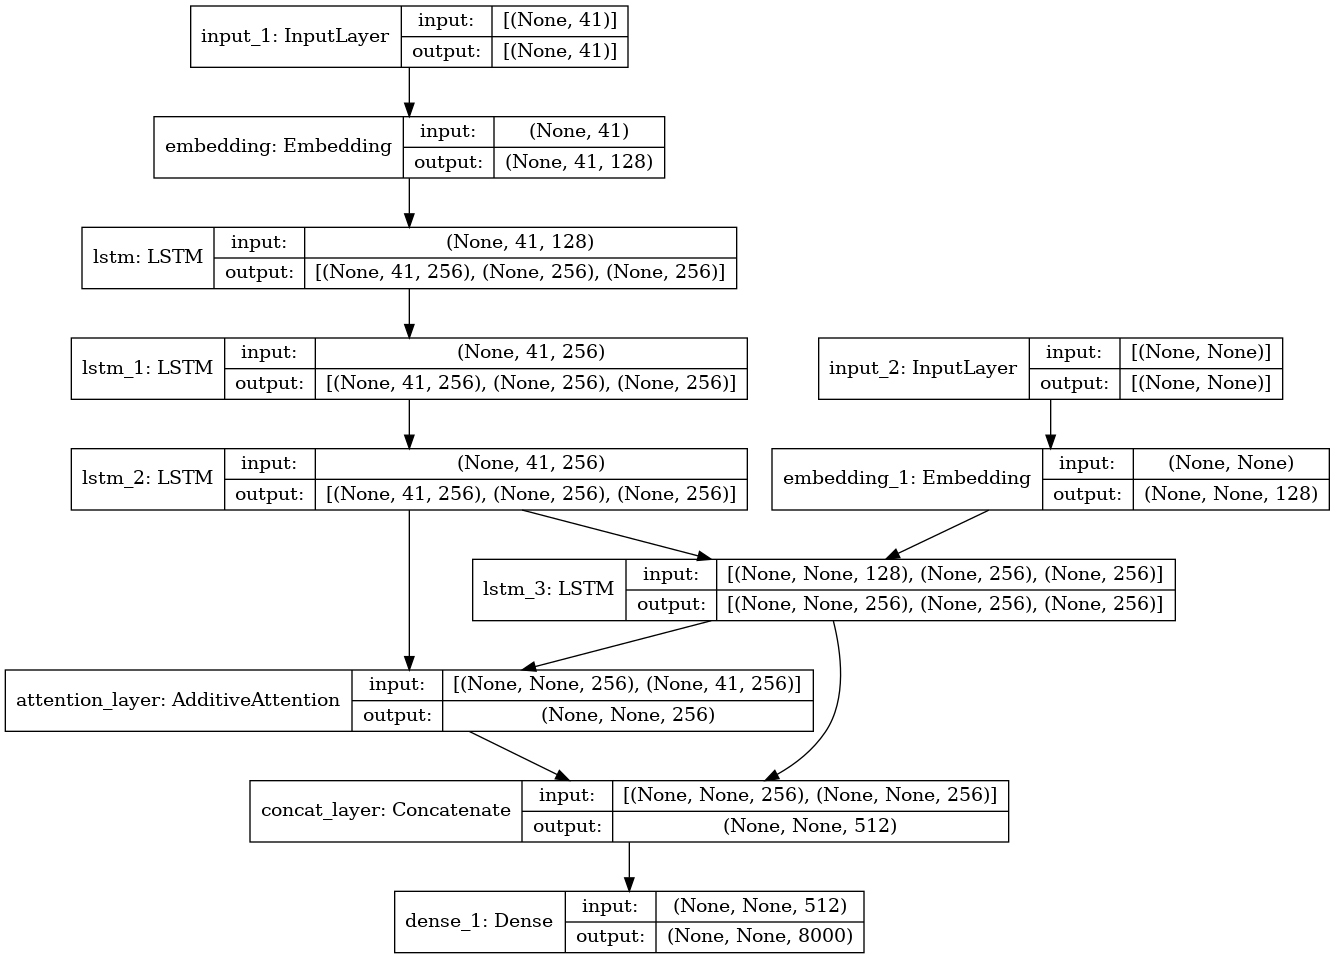

In [55]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()
plot_model(model, show_shapes=True)

&nbsp;

__모델 훈련__

설계한 모델로 훈련을 진행해보자.

In [56]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(
    x=[encoder_input_train, decoder_input_train], 
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
278/278 [==============================] - 52s 87ms/step - loss: 5.8244 - val_loss: 5.4089
Epoch 2/50
278/278 [==============================] - 22s 81ms/step - loss: 5.2416 - val_loss: 5.0577
Epoch 3/50
278/278 [==============================] - 23s 83ms/step - loss: 4.9081 - val_loss: 4.8325
Epoch 4/50
278/278 [==============================] - 23s 84ms/step - loss: 4.6279 - val_loss: 4.5986
Epoch 5/50
278/278 [==============================] - 24s 86ms/step - loss: 4.4023 - val_loss: 4.4483
Epoch 6/50
278/278 [==============================] - 24s 88ms/step - loss: 4.2206 - val_loss: 4.3322
Epoch 7/50
278/278 [==============================] - 24s 87ms/step - loss: 4.0673 - val_loss: 4.2618
Epoch 8/50
278/278 [==============================] - 24s 87ms/step - loss: 3.9311 - val_loss: 4.1643
Epoch 9/50
278/278 [==============================] - 24s 87ms/step - loss: 3.8106 - val_loss: 4.0924
Epoch 10/50
278/278 [==============================] - 24s 87ms/step - loss: 3.700

훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 하여 살펴보자.

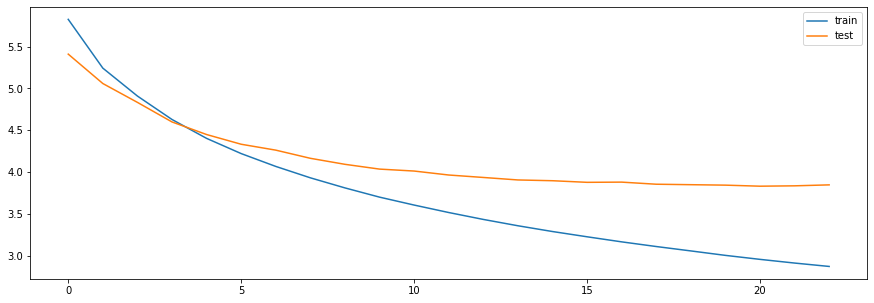

In [57]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

&nbsp;

### Step 5. 실제 결과와 요약문 비교하기 (추상적 요약)

<hr>

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보자.

&nbsp;

__인퍼런스 모델 구현__

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로

그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고

디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

그러나 정답 문장이 없는 인퍼런스 단계에서는,

만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에

부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다.

이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 

필요한 3개의 사전을 아래와 같이 미리 준비한다.

In [58]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

인코더 설계는 뒤에 나올 decode_sequence() 구현 부분과 함께 보면 이해에 도움이 된다.

In [59]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = \
    decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

출력층 설계에서도 이전에 사용한 어텐션 기법을 사용한다.

In [60]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

decode_sequenct 함수는 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수이다.

In [61]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인 하고자 한다.

아래에는 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 각각 함수의 코드가 있다.

Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고,

Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 구성한다.

In [62]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=""
    for i in input_seq:
        if (i != 0):
            temp = temp + src_index_to_word[i]+" "
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=""
    for i in input_seq:
        if ((i != 0 and i != tar_word_to_index["sostoken"]) and i != tar_word_to_index["eostoken"]):
            temp = temp + tar_index_to_word[i] + " "
    return temp

이제 테스트 데이터 약 10개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보자.

In [63]:
print(len(encoder_input_train))
print(len(encoder_input_test))

70928
17731


In [64]:
for i in np.random.randint(len(encoder_input_test), size=10):
    print("Idx :", i)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]).strip())
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)).strip())
    print("\n")

Idx : 10673
원문 : picture shows actors rishi kapoor prem chopra filmmaker rakesh roshan along actor birthday celebrations actor turned friday picture shared daughter ekta kapoor instagram photograph captioned last 
실제 요약 : pic shows rishi rakesh prem at th birthday
예측 요약 : pic shows srk with him from his birthday


Idx : 5689
원문 : voting ended first phase chhattisgarh assembly election voter turnout till pm election commission said figures updated later election commission added nearly one lakh security personnel deployed eight districts amid threat maoists called boycott elections 
실제 요약 : turnout as voting ends for st phase chhattisgarh polls
예측 요약 : voting for lok sabha polls in chhattisgarh polls


Idx : 12099
원문 : talking billionaire elon musk led electric car maker tesla american investor jim said company headed brick wall also said short tesla lost money know company stock decline tesla stock price fall company fall added 
실제 요약 : tesla headed for wall investor jim
예측 요약 : tesla 

원문에서 요약 문장을 예측 해 본 결과와, 실제 요약 문장을 비교해 보면,

어느정도 핵심 단어들 중 일부가 요약문장안에 포함 된 것을 확인할 수 있다.

하지만 예측 요약 문장을 번역해보면 조금 실망스러운 결과를 확인 할 수 있다.

이전 노드인 기계 번역기의 경우는 기대이상으로 성능이 좋았었는데,

이번 요약문은 아무래도 사람이 느끼는 가장 중요한 핵심단어를 파악하기에는,

아직은 어려움이 제법 있는 것 같다.

&nbsp;

### Step 6. Summa을 이용해서 추출적 요약해보기

<hr>

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 

추출적 요약에 비해서 난이도가 높다.

반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고,

기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다고 할 수 있다.

Summa의 summarize를 사용하여 추출적 요약을 해보자.

- `Summa`：에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있는 패키지

- summarize() 사용하기

  + text (str) : 요약할 테스트.
  
  + ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
  
  + words (int or None, optional) – 출력에 포함할 단어 수.

  + 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.

  + split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
  
  + 문장 토큰화를 별도로 하지 않아도 내부적으로 문장 토큰화를 수행. (원문을 바로 입력 가능)

이전에 테스트 데이터 약 10개의 샘플에 대해

실제 요약과 예측된 요약을 비교하는 코드를 조금 개량하도록 하겠다.

In [65]:
from summa.summarizer import summarize
print(version('summa'))

1.2.0


In [66]:
df_news

,Content,Headlines,Text,Summary,decoder_input,decoder_target
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,Pakistani singer Rahat Fateh Ali Khan has deni...,Rahat Fateh Ali Khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,Weeks after ex-CBI Director Alok Verma told th...,Govt directs Alok Verma to join work 1 day bef...,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
...,...,...,...,...,...,...
98256,"Pakistan has started building a nearly 2,400-k...",Pakistan starts building fence along Afghanist...,pakistan started building nearly kilometer fen...,pakistan starts building fence along afghanist...,sostoken pakistan starts building fence along ...,pakistan starts building fence along afghanist...
98257,A CRPF jawan was on Tuesday axed to death with...,CRPF jawan axed to death by Maoists in Chhatti...,crpf jawan tuesday axed death sharp edged weap...,crpf jawan axed to death by maoists in chhatti...,sostoken crpf jawan axed to death by maoists i...,crpf jawan axed to death by maoists in chhatti...
98258,"'Uff Yeh', the first song from the Sonakshi Si...",First song from Sonakshi Sinha's 'Noor' titled...,uff yeh first song sonakshi sinha starrer upco...,first song from sonakshi sinha noor titled uff...,sostoken first song from sonakshi sinha noor t...,first song from sonakshi sinha noor titled uff...
98259,"According to reports, a new version of the 199...",'The Matrix' film to get a reboot: Reports,according reports new version science fiction ...,the matrix film to get reboot reports,sostoken the matrix film to get reboot reports,the matrix film to get reboot reports eostoken


In [67]:
### TEST  ─────────────────────────────────────────────────
temptext = seq2text(encoder_input_test[36])
print("Text  :", seq2text(encoder_input_test[36]))
print()
print("df_news['Content'][882] :", df_news['Content'][882])
print("summa :", summarize(df_news['Content'][882], ratio=0.5))
print(len(df_news))
### TEST  ─────────────────────────────────────────────────

Text  : janhvi kapoor talking late mother actress sridevi said cannot even wanted year brought worst best experience life little strange family united big thing whatever heavy added janhvi 

df_news['Content'][882] : Actor Govinda's 34-year-old nephew Janmendra Ahuja passed away on Thursday morning after suffering from a heart attack. According to reports, he had complained of chest pain in the morning, following which he collapsed. Janmendra had directed a film titled 'Jahan Jaaeyega Hamen Paaeyega' which starred Govinda in the lead role.
summa : Actor Govinda's 34-year-old nephew Janmendra Ahuja passed away on Thursday morning after suffering from a heart attack.
88659


기존에 추상적 요약 출력시 사용했던 코드를 약간 수정해서,

뉴스 데이터의 인덱스, 텍스트, 타겟(헤드라인), 추상적 요약, 추출적 요약 5개의 항목을 출력하도록 하였다.

내용 작성을 동일하게 하기 위해 인덱스를 임의의 값으로 고정하였다. 출력부분을 확인해 보자.

In [81]:
# for i in [1561, 10331, 7042, 16588, 9411, 1862, 748, 9239]:
for i in [1561, 10331, 7042, 16588, 9411, 1862, 748, 9239]:
    print("Idx  :", i)
    
    sText = seq2text(encoder_input_test[i])
    sSummary = seq2summary(decoder_input_test[i]).strip()
    sAbst = decode_sequence(encoder_input_test[i].reshape(1, text_max_len)).strip()
    
    print("Text :", sText)
    print("Summary     :", sSummary)
    print("Abstractive :", sAbst)
    
    ## Summary 글자를 포함하는 원본 데이터셋의 인덱스를 찾는다.
    idx_summs = df_news.index[df_news["Summary"].str.contains(sSummary)].tolist()
#     print(idx_summs)
    idx_summs = idx_summs.pop()    ## 리스트에서 하나를 꺼낸다.
    
#     print(type(idx_summs))
#     print(df_news["Content"][idx_summs])
    
    print("Extractive  :", summarize(df_news["Content"][idx_summs], ratio=0.5))
    print("─" * 64)

Idx  : 1561
Text : rbi adequate reserves transfer lakh crore lakh crore government bank america lynch said investment bank estimated surplus funds rbi country gdp rbi november decided set expert panel examine economic capital framework 
Summary     : rbi can transfer lakh crore to government
Abstractive : rbi clears of crore loan to banks
Extractive  : The investment bank estimated surplus funds with the RBI at 0.5-1.6% of the country's GDP.
────────────────────────────────────────────────────────────────
Idx  : 10331
Text : sri lanka registered first victory india two years registering five wicket win tri series opener tuesday india seven match winning streak island nation came end india first defeat rohit sharma captaincy five matches 
Summary     : sri lanka win vs india for first time after years
Abstractive : sri lanka beat sa to win their st ever test
Extractive  : Further, this was India's first defeat under Rohit Sharma's captaincy in five T20I matches.
────────────────────────

추상적, 추출적 방법 모두 출력이 되어서, 원본과 한눈에 비교 할 수 있다.

다만, 위 내용이 과연 잘 추출 되었는지에 대한 정량적 평가방법이 루브릭 항목에 포함되어 있으나,

실습노드에서는 해당 부분에 대한 레퍼런스등이 제시되지 않았다.

언어모델의 성능 측정을 위한 평가 방법으로

펄플렉서티(perplexity, PPL), BLEU(Bilingual Evaluation Understudy) 등의 방법이 있다고

외부 참고자료에서 찾아 볼 수 있었지만, 이것들은 기계 __번역__ 의 성능 평가에 주로 사용된다고 한다.

#### ▶ ROUGE(Recall-Oriented Understudy for Gisting Evaluation)

자료를 탐색하면서, Rouge 라는 평가지표가 있다는 것을 알게 되었다.

ROUGE(Recall-Oriented Understudy for Gisting Evaluation)는 주로 텍스트 요약 태스크를 평가하는데 사용한다고 한다.

그리고 한글 요약 성능 평가지표로는, RDASS, rouge-u, rouge-su 가 적합하다고 한다. 허나, 여기서는 영문 요약이다.

rouge 평가가 이번 프로젝트에 적당한 방법이라고 생각해서, 적용하여 평가를 수행해 보도록 하겠다.

우선 간단한 사용법은 아래와 같다.

In [84]:
!pip install rouge

In [85]:
### Rouge 사용 TEST ──────────────────────────────────────────────────────
from rouge import Rouge

model_out = ["he began by starting a five person war cabinet and included chamberlain as lord president of the council",
             "the siege lasted from 250 to 241 bc, the romans laid siege to lilybaeum",
             "the original ocean water was found in aquaculture"]

reference = ["he began his premiership by forming a five-man war cabinet which included chamberlain as lord president of the council",
             "the siege of lilybaeum lasted from 250 to 241 bc, as the roman army laid siege to the carthaginian-held sicilian city of lilybaeum",
             "the original mission was for research into the uses of deep ocean water in ocean thermal energy conversion (otec) renewable energy production and in aquaculture"]

rouge = Rouge()
rouge.get_scores(model_out[0], reference[0])
# rouge.get_scores(model_out, reference, avg=True)


[{'rouge-1': {'r': 0.7368421052631579,
   'p': 0.7777777777777778,
   'f': 0.7567567517604091},
  'rouge-2': {'r': 0.5, 'p': 0.5294117647058824, 'f': 0.514285709289796},
  'rouge-l': {'r': 0.7368421052631579,
   'p': 0.7777777777777778,
   'f': 0.7567567517604091}}]

Rouge 결과를 통해 확인 할 수 있는 평가 항목은 다음과 같이 설명할 수 있을 것이다.

- rouge-1：예측한 요약문과 실제 요약문 간의 unigram의 재현율

- rouge-2：예측한 요약문과 실제 요약문 간의 bigram 재현율

- rouge-l：예측 요약 문과 실제 요약문이 일치하는 정도.


- r：재현율. label 을 구성하는 단어 중 몇개가 inference 와 겹치는가？

  + 우선적으로 필요한 정보들이 다 담겨있는지 체크

- p：정밀도. inference 를 구성하는 단어 중 몇개가 label 과 겹치는가？

  +  요약된 문장에 필요한 정보만을 얼마나 담고있는지를 체크

- f：r 과 p 를 기반으로 하여 f1 score 측정한 값


- 예측한 요약문과, 라벨(헤드라인)을 비교하여 rouge 평가를 한다.<br>
　→ 추상적：추출적 요약문을 서로 비교하는것이 아니다.

그러면 rouge 를 사용하여 앞서 추출적 요약에 대한 코드를 조금 더 변경하여 rouge 평가 결과를 출력하고

이를 정리해서 표로 꾸며보도록 하겠다.

In [86]:
for i in [1561, 10331, 7042, 16588, 9411, 1862, 748, 9239]:
    print("Idx  :", i)
    
    txt = seq2text(encoder_input_test[i])
    summ = seq2summary(decoder_input_test[i]).strip()
    abst = decode_sequence(encoder_input_test[i].reshape(1, text_max_len)).strip()
    
    print("Text :", txt)
    print("Summary     :", summ)
    print("Abstractive :", abst)
    print("score：", rouge.get_scores(abst, summ))
    
    ## Summary 글자를 포함하는 원본 데이터셋의 인덱스를 찾는다.
    idx_summs = df_news.index[df_news["Summary"].str.contains(summ)].tolist()
    idx_summs = idx_summs.pop()    ## 리스트에서 하나를 꺼낸다.
    
#     print(type(idx_summs))
#     print(df_news["Content"][idx_summs])
    extra = summarize(df_news["Content"][idx_summs], ratio=0.5)
    print("Extractive  :", extra)
    print("score：", rouge.get_scores(extra, summ))
    
    print("─" * 64)

Idx  : 1561
Text : rbi adequate reserves transfer lakh crore lakh crore government bank america lynch said investment bank estimated surplus funds rbi country gdp rbi november decided set expert panel examine economic capital framework 
Summary     : rbi can transfer lakh crore to government
Abstractive : rbi clears of crore loan to banks
score： [{'rouge-1': {'r': 0.42857142857142855, 'p': 0.42857142857142855, 'f': 0.4285714235714286}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.42857142857142855, 'p': 0.42857142857142855, 'f': 0.4285714235714286}}]
Extractive  : The investment bank estimated surplus funds with the RBI at 0.5-1.6% of the country's GDP.
score： [{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
────────────────────────────────────────────────────────────────
Idx  : 10331
Text : sri lanka registered first victory india two years registering five wicket win tri series opener 

이 내용을 정리하면 아래와 같다.

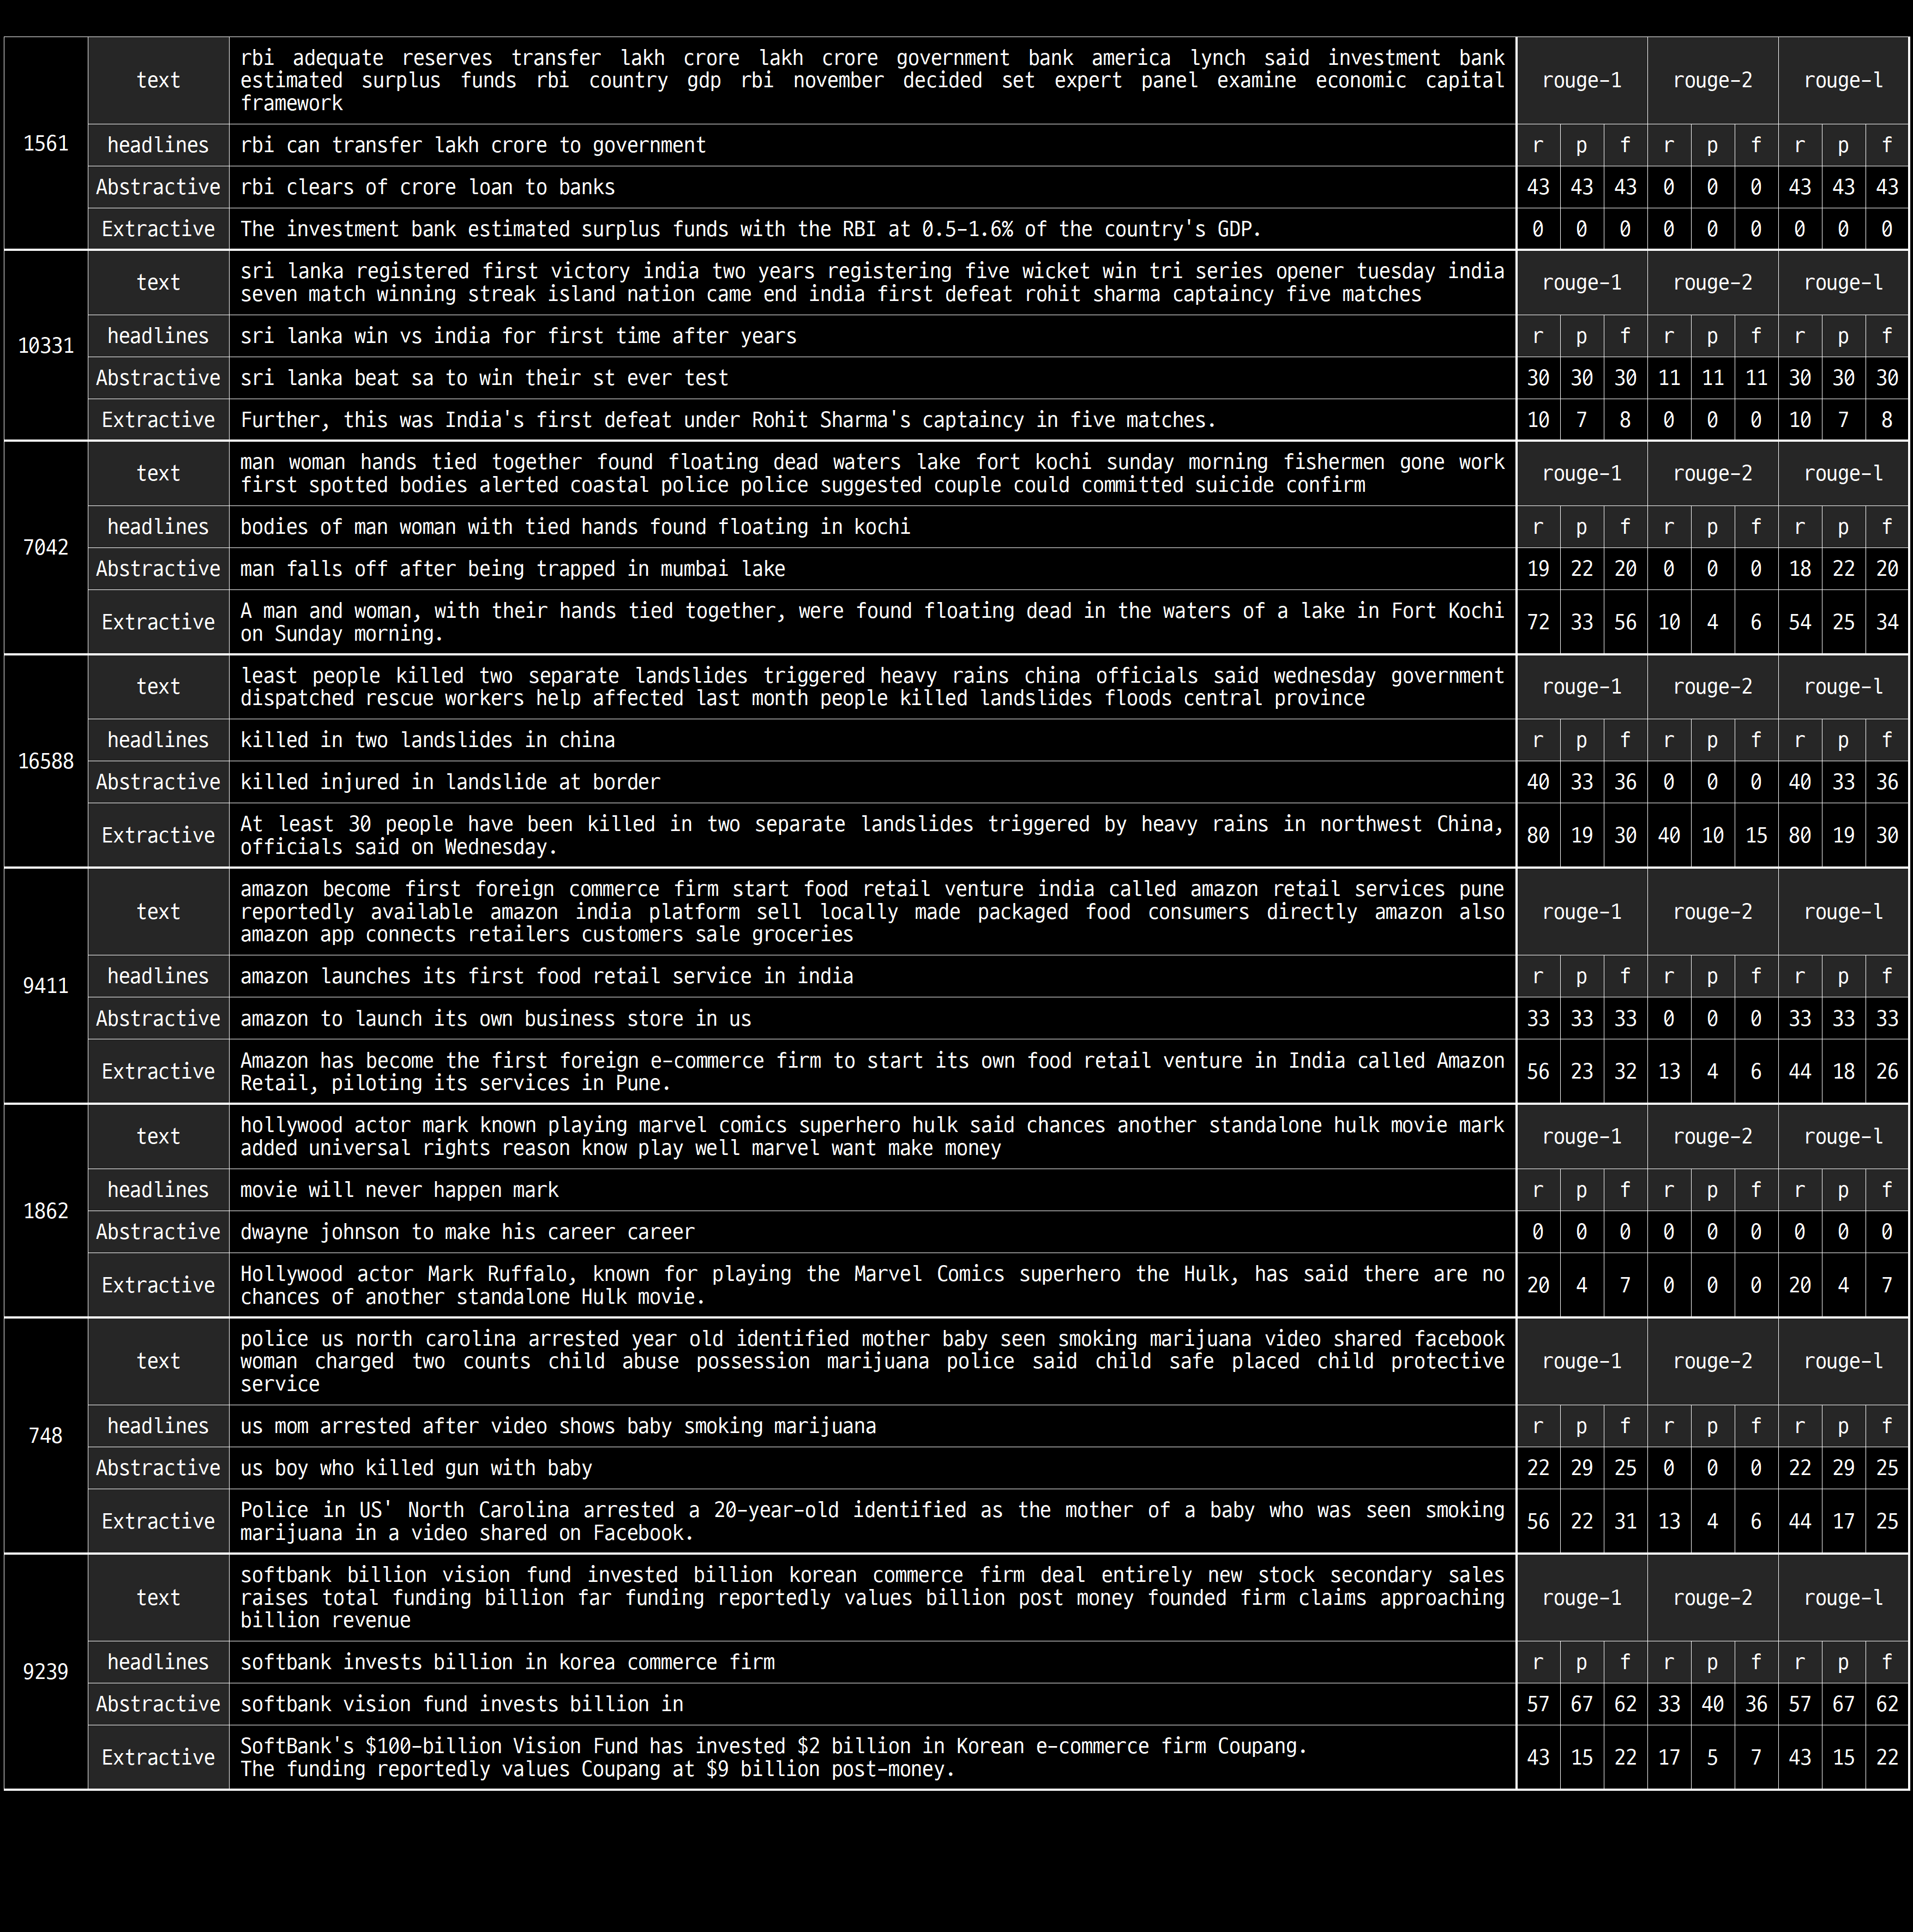

rouge-1, rouge-2, rouge-l 값을 모두 정리해놓고 보니, 뉴스 요약봇의 성능은 그렇게까지 성공적이라고 보이진 않는다.

기본적으로는 rouge-l 값을 보면 되는데, 그래도 혹시 rouge-2 스코어가 높은게 하나쯤은 나오지 않을까 싶어서 전부 사용하였는데,

그래도 셔플을 거쳐온 16588 인덱스 결과같은 경우, rouge-2 값이 제법 괜찮게 나온다.

메트릭 지표를 이해한 내용에 따르면, rouge 평가는 이러한 자연어 요약 생성 부분에서는 굉장히 합리적이라는 생각이 든다.

설명대로, 요약문의 평가에는 적절한 지표라고 생각된다.

매우 간단한 사용법에 비해, 핵심단어의 포함과 두 단어의 관계성을 상호 비교하여

rouge-n, rouge-l 지표를 빠르게 확인 할 수 있어서, 요약내용은 그저 그랬지만, rouge 평가는 제법 만족스럽다.

참고로, 한글의 경우 RDASS 방법이 있다고 이전에 서술했는데, rouge 만큼 간단히 사용 할 수 있을것 같아보이지는 않는다.

&nbsp;

▶ 최종 요약 결과에 대한 생각

영어라서인지 비교적 요약이 잘 된것도 확 좋다는 느낌은 들지 않는다.

전반적으로 훌륭한 요약이라는 생각은 들지않지만, 

rouge 스코어가 높은 요약 문장들의 경우, 꽤나 좋은 느낌이다.

중요한 단어도 포함 되어있는 것은 물론이고, 문법적으로도 그럭저럭 괜찮은 문장들이다.

(아무래도 헤드라인이라는 이유로, 약간의 어색함은 어느정도 용인되는 점도 있을 것이다.)


아쉬운점을 말하자면, (사실은 이 이야길 하고 싶었다.)

중요한 단어가 포함되고 그럭저럭 괜찮은 문장인데 요약이 전혀 앞뒤가 안맞는것도 흔하다.

아무래도 제공되는 뉴스 데이터셋의 텍스트가 요약을 하기에는 꽤 짧은 것 같다.

데이터의 수는 적당 했다고 생각이 드는데, 본문의 길이가 너무 짧은것 같다.

뉴스들의 카테고리도 스포츠부터 연예 정치 사회 등등 꽤 넓은 범위인것 같기는 하지만,

가장 관심있게 지켜봤던, ㅡ 기사 본문에는 찾을 수 없는 단어가 추상적 요약에는 등장 ㅡ 하는 사례를,

생각보다 많이 찾아 볼 수 없어서 살짝 아쉬웠다. (기대만큼 많지 않았다.) 없지는 않다.

없지는 않은데, 본 내용에 없다가 나타난 단어가, 딱 의미에 맞는 적당한 단어가 아닌것이 많아서 문제인것 같다.

위의 결과에서도 Index 748 에서 child(어린이) 라는 단어만 있음데도 boy(소년) 라는 단어가 나온다.

child 가 girl 인지 boy 인지는 무엇을 근거로 추상적 요약을 수행한것일까？

물론 내용부터가 꽝이어서 특별히 거론할 내용은 아니지만, 어떨때는 단어가 정말 제멋대로 나오는 경우가 있는것 같다.

살펴보면 은근히 문장이 말이 되는거랑, 내용을 제대로 요약 했는가를 따져보면 아쉬운 점이 많다.

그 와중에 잘 한거는 또 상당히 잘 한것도 보이지만 이게 참, 실제로 쓸라면 부족한 점이 꽤 많다는 생각이다.

향후에 학습할 어텐션 외의 최신의 기법들을 적용하면 이런 점들을 좀 더 개선할 수 있을지 궁금해지는 부분이다.

&nbsp;

<hr>

### ■ 프로젝트 회고

#### 1) 이번 프로젝트에서 '어려웠던 점'

이번 프로젝트는 상대적으로 노드 실습 부분의 내용이 꽤 촘촘하게 짜여져 있었다.

그래서 전반적으로는 생각보다 어렵진 않았다.

한가지 조금 고생했던 점은, summa 라이브러리를 사용 할 때에,

전처리가 끝난 내용을 넣을 경우 추출적 요약기능이 전혀 동작하지 않는다는 것이었다.

덕분에 이쁘게 순서 맞춘다고, 데이터셋 처음부터 다시 구성하느라 학습 다시 진행했다.

그랬는데, 데이터셋 잘 못 만들어서 인덱스 꼬이고 … 거기서 고생을 많이 했다.

그래도 어느정도 차질없게 원활한 코드실행을 고려하여 구성해 놓고 나니까

생각보다는 깔끔하게 수행이 되어서, 지금까지 NLP 파트 프로젝트 중에서는

물론 마감시간이 다가와서 촉박했던것은 여전하지만

서너시간 정도만 분노상태였고, 대부분은 잔잔한 마음으로 진행한 것 같다.

#### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

seq2seq 모델의 경우, 번역기에서도 한번 다루어졌던 내용인데,

이 모델이 텍스트 요약 분야에서도 이렇게 쓸모가 있을지 솔직히 예상치 못했다.

LSTM 도 마찬가지다, 상당히 자주 거론되는 RNN 도 그렇고.

NLP 분야에서는 이러한 것들을 응용해서 정말 별의 별 생각치도 못했던 일들을 해내는걸 보면

이러한 개념을 정립하고, 구체적인 접근법을 모델에 반영하여 결과적으로 ＂그게 되겠어？＂ 싶은 것들을

실제로 내가 생각하는 어느정도 수준 이상으로 동작이 되는것을 가끔은 경이롭기까지 하다.

이번 프로젝트 에서, 다시한번 LSTM 과 seq2seq 를 다루어 보았지만, 두세번이 아니라

앞으로도 계속 자주 보게 될 것 같은 생각이 든다.

그러고보면 LSTM 은 저번에 텍스트 감성분석에서도 기대이상으로 맹활약을 해서 루브릭을 돌파해줬었다.

그리고 토큰화, 인코딩 등의 과정도 상당히 중요하게 다루어지는 개념들인데,

이번 프로젝트에서 데이터셋 전처리를 진행하면서 다시 한번 실습을 해 보게 되었다.

부가적으로, 자연어처리 분야에서 평가 척도로 활용 할 수 있는 평가 모델들에 대해서도

자료조사를 하면서 자연스럽게 학습하게 되었고, 실제로 본 프로젝트에서 적용 하였다.

#### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

추상적 요약의 경우 복잡한 구성이긴 했지만, 과정을 거치면서 seq2seq 와 어텐션을 활용하며

새로운 개념들에 대해 알 수 있게 되는 시간이었다.

두 요약방식 모두, 문장 구성이나 핵심 단어들이 포함되어 있거나 하는 등의 결과를 보면

생각보다 괜찮은 모델이라는 생각이 들지만, 

사실 추출적 요약의 경우 라이브러리를 사용해서 그런지 내부적으로 어떻게 동작했는지 잘 모르겠다.

그냥 이것도 텍스트 랭크 같은 알고리즘으로 추출적 요약이 되나보다ㅡ 하고 넘어간 셈인데.

추상적 요약에 비해 간단하고 쓰기 좋은 것 같지만, 여러가지 문제점들을 발견할 수 있었다.

물론 summa 모델만의 문제일수도 있지만.

프로젝트 진행중에 그러한 문제점들을 비교하고 다른 추출적 요약 모델을 사용하려고 생각도 했었는데,

어차피 당장에는 내부적인 구성을 알 수 있을 것 같지도 않고, 괜히 또 충돌 발생시켰다가

새로운 시도 하느라 기나긴 학습과 촉박한 시간을 생각하여 gensim 라이브러리 사용할까 했던 마음을

다행스럽게도 다운시킬 수 있었다. (대신에 데이터셋 다시 잡느라 결국 학습 여러번 다시 돌렸지만)

추상적 요약과 추출적 요약 사실 두가지 다 개인적으로는 만족스럽지는 않았다.

객관적으로 보자면 뭐 이정도면 나쁘지 않다고, 할 수 있겠지만, 주관적으로는 그저 그런 느낌이다.

최근에는 인터넷 뉴스 기사들의 경우 낚시성 제목의 헤드라인들을 워낙 많이 접하다보니,

결국 나도 사람이라, 호기심 반 자극적인 내용 좋아하는것 반, 해서 헤드라인에 팍 꽂히는, 그런 점을 내심 기대했던 것일까.

문장 요약의 경우 사람으로 표현하자면, 정직한데 조금 모자란 것 같은 느낌이었다.

추출적 요약의 경우 키워드 설정이 가능하던데, 추상적 요약에서도 그와 비슷한 방법을 쓴다면,

클릭 유도성 다분한 헤드라인 같은것들도 어떻게 잘 하면 뽑을 수 있지 않을까 하는 점이 궁금한 점으로 남는다.

#### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

기본적으로 루브릭 평가 지표를 달성하고자 베이스라인에 가까운 깔끔한 실행 순서를 따르는 코드를 완성하고자 했다.

전처리 과정에서 데이터셋의 구성과 이상치 등을 검색하여 단어사전의 효율을 올리고자 노력했다.

결과적으로 효율이 예상만큼 좋아지지는 않았지만, 데이터셋을 꾸준히 모니터링 하면서 따라가서

나름 괜찮게 잘 정리를 하고자 했던 계획을 실행에 옮긴것에 큰 의미를 두고 싶다.

그 외에, 세번째 루브릭 평가 문항에 관한 내용을 조사하여 적용하였고, 결과 비교도 깔끔하고 고급진 모양새로 정리했다.

그 과정에서 요약 문장들을 번역도 해 보고 하였으나, 이번에는 번역 하자니 원문도 번역기 돌린 내용을 적어야 할 것 같았다.

그런데, 뭔가 원문과 요약문장들을 번역기에 넣다보니 번역이 생각보다 잘 안되는것 같고,

그렇다고 내가 직접 번역하자니, 나도 확신이 없어서, 괜히 어색하게 발번역 내용 적어넣자니,

(번역기때와 달리 문장도 길어진 데다가 전처리 과정에서 번역기에 불리한 문장으로 전처리 되어버렸다.)

그냥 비슷한 단어들 몇개 있는 것 찾아다가, 글자 색상 바꾸어서 편집해 놓자고 처음에는 생각했었다.

그러던 와중에, summa 가 말썽을 일으켜서 이것저것 자료를 찾다가,

문장 요약 성능 평가에 적합한 rouge 를 발견하여, 그것을 실제로 테스트 하고 적용 해 보았다.

rouge 성능 평가가 나름 사용법도 간단한데, 여러 분석 결과가 타당한 것 같아서 제법 마음에 들었다.

그 정도의 성능 평가가 있으니, 굳이 발번역의 내용을 넣지 않아도 될 것 같다는 생각이 들어서 번역은 넣지 않았다.

#### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

이번에도 역시, 늘 하는 이야기인 것 같지만, 기본적으로 시작은 역시 베이스라인에 충실해야 한다는 느낌이다.

실행했을때 일단 원활히 돌아가는게 반 이상 차지한다고 생각한다.

노드 학습/실습 부분을 제대로 따라왔다는 전제가 곧 성능과 상관없이 실행에 문제가 없어야 한다는 점이다.

이번 프로젝트도 다행스럽게, LSTM, 어텐션 적용 과정에서의 모델설계 부분에서 실수가 없어서인지,

기본에 충실하고 평가지표의 내용을 실험 해 보다가 괜찮게 나오는 결과 확인하면,

그게 루브릭 달성을 위한 노력을 한 것이고, 루브릭 달성 한 것이라고 생각한다.

다만, 한가지 위험할 뻔 했던 나의 경험을 이야기 하자면,

summa 적용시에 문제되는 사항이 있어서, 그 부분 때문에 뭘 잘못 건드리거나ㅡ

전처리 또는 코드 구조에서 실수가 있었을 경우, Extractive 요약 결과가 빈 값으로 나올 수 있는데,

이를 극복하지 못한다면 일단은 추출요약이 안되니까 1개 달성 실패할 수 있을 것이며,

이것들을 비교 분석 결과를 표로 만드는 세번째 루브릭도 당연히 못하게 될 테니,

최종적으로는 루브릭 2개는 실패할 위험이 있다고 생각한다.

전처리 과정을 체계적으로 진행 한다면 그 2개는 극복을 할 수 있다.

따라서 전처리 과정부터 실패하면 남은 1개 마저도 실패하게 될 것이다.

결론은ㅡ 결국 제일 중요한건 시작이 반이라고, 

전처리 부분부터 확실히 진행하면 루브릭 평가 지표는 어지간해선 달성한다고 생각한다.

또 늘 회고에 쓰는 내용을 적어놓은 것 같다. 그치만 사실인걸…

#### 6) 자기 다짐

심화과정을 NLP 파트를 선택했는데, 앞으로 가야 할 길이 정말 먼 것 같다.

이 프로젝트도 무사히 수행하고 루브릭 평가 부분도 아쉬움은 없지만, 아직 쓴맛을 못본것 같다 나는.

그리고 이번 프로젝트 진행하면서, 아직도 익숙해 지지 않은 자주 보게 될 것 같은 그 것들을

돌아서면 까먹는 지금 상황을 극복해야 할 필요가 있기 때문에, 이 부분을 좀 보완해야 할 것 같다.

그런데 맨날 하겠다고 하고 시간없고 바쁘네 뭐네 핑계대고 안하는 몹쓸 의지력…

방학이 무섭다. 놀다와서 다 까먹지 말고, 그간 수행했던 NLP 파트 프로젝트들 다시 복습 하던가 해야겠다.

<hr>

## ◎ Reference

- (AIFFEL) Exploration Project Node 10. 번역기를 만들어보자

- (AIFFEL) Exploration Project Node 12. 뉴스 요약봇 만들기

- [Sequence-to Sequence](https://boysboy3.tistory.com/m/113)

- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

- [Attention in RNN-Encoder-Decoder](https://sonsnotation.blogspot.com/2020/11/11-attention-transformer-models.html)

- (언어모델 성능측정) [BLEU(Bilingual Evaluation Understudy) score](https://wikidocs.net/31695)

- (Rouge) [Rouge score - Summarization의 평가 Metric](https://velog.io/@crosstar1228/NLPRouge-score-Summarization%EC%9D%98-%ED%8F%89%EA%B0%80-Metric)

- (Rouge) [ROUGE 평가 지표 이해하기](https://ariz1623.tistory.com/307)

- (언어모델 평가) [자연어 생성과 평가 방법 (NLP generation evaluation)](https://blog.testworks.co.kr/nlp-generation-evaluation/)

<hr>